### ***BINARY CLASSIFICATION PROBLEM***
MỤC TIÊU CỦA BÀI NÀY LÀ PHÂN LOẠI 1 ĐIỂM THUỘC VÒNG TRÒN TRONG HAY NGOÀI (0 hoặc 1)

In [1]:
import torch
torch.manual_seed(42)

In [2]:
from sklearn.datasets import make_circles
X,y = make_circles(n_samples=1000, noise = 0.03, factor= 0.7, random_state=42)

<Axes: xlabel='X1', ylabel='X2'>

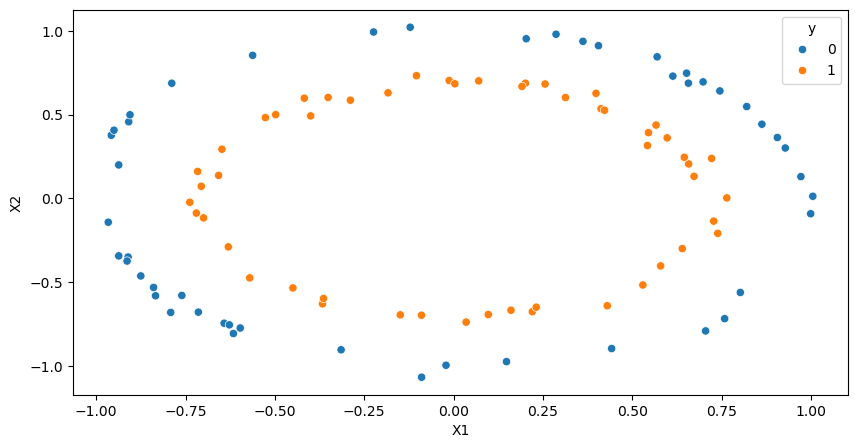

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
plt.figure(figsize=(10,5))
circle = pd.DataFrame({"X1":X[:100,0], "X2":X[:100,1], "y":y[:100]})
sns.scatterplot(x = circle['X1'], y = circle['X2'], hue =circle['y'] )


In [4]:
X.shape, y.shape #X1 là x, X2 là y, y là vòng trong/ngoài

((1000, 2), (1000,))

##### ***BÀI TOÁN PHÂN LOẠI ĐIỂN HÌNH***
Cho tập hợp Circle, với điểm ảnh nằm ở X1, giá trị X2, thì label là 0 hay 1 (nằm ở vòng tròn ngoài hay trong)

In [5]:
from torch.utils.data import TensorDataset,DataLoader
device = torch.device('cuda:0')

In [6]:
X = torch.Tensor(X).type(torch.float).to(device)
y = torch.Tensor(y).type(torch.float).to(device)


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8)
X_train.shape, y_train.shape
y_train, y_test = y_train.unsqueeze(1), y_test.unsqueeze(1)

In [8]:
train_TD = TensorDataset(X_train,y_train)
test_TD = TensorDataset(X_test,y_test)
bs = 20
train_DL = DataLoader(train_TD, batch_size = bs)
test_DL = DataLoader(test_TD, batch_size = bs)

In [9]:
for X,y in train_DL :
    print(X[0], y[0])
    print(X.shape, y[0].shape)
    break

tensor([ 0.7303, -0.1215], device='cuda:0') tensor([1.], device='cuda:0')
torch.Size([20, 2]) torch.Size([1])


In [10]:
from torch import nn
class binary_class(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.Layers = nn.Sequential(
            nn.Linear(2,5), # X đưa vào model có 2 giá trị X1, X2. Phân tích thành 5 features
            nn.ReLU(),
            nn.Linear(5,1), # Từ 5 features trả về giá trị y label có 1 giá trị (phân loại)
        )
    def forward(self, X) :
        return self.Layers(X)
model_0 = binary_class().to(device)

In [11]:
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}\nKet luan: Du doan nhu shit")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 1])

First 10 predictions:
tensor([[-0.0842],
        [-0.3111],
        [-0.3495],
        [-0.1151],
        [-0.1464],
        [-0.1269],
        [-0.0840],
        [-0.1793],
        [-0.3030],
        [-0.3740]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([[0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.]], device='cuda:0')
Ket luan: Du doan nhu shit


In [12]:
loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.SGD(params = model_0.parameters(), lr = 0.04)

In [13]:
for X,y in train_DL :
        preds = model_0(X)
        print(X.shape, preds.squeeze().shape, y.shape)
        break

torch.Size([20, 2]) torch.Size([20]) torch.Size([20, 1])


In [14]:
def accuracy_pts(preds, y) :
    correct = (torch.round(preds)==y).sum().item()
    return correct

In [15]:
y_pred = torch.round(model_0(X_test[:5]))
loss, accuracy=0,0
model_0.eval()
with torch.inference_mode() :
    for Xt,yt in test_DL :
                preds = model_0(Xt)
                loss += loss_fn(preds, yt).item() # đây là sai số chung cho 1 batch
                accuracy+=accuracy_pts(preds, yt)
print(accuracy)

96


In [16]:
def train_loop(model, dataloader, loss_fn, optim) :
    model.train()
    for batch,(X,y) in enumerate(dataloader) :
        logits = model(X)
        loss = loss_fn(logits, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
def test_loop(model, dataloader, loss_fn) :
    model.eval()
    loss = 0
    accuracy=0
    with torch.inference_mode() :
        for X,y in dataloader :
            preds = model(X)
            loss += loss_fn(preds, y).item() # đây là sai số chung cho 1 batch
            accuracy+=accuracy_pts(torch.sigmoid(preds), y)
    print(f"sai so trung binh: {loss/len(dataloader)}")
    print(f"do chinh xac trung binh: {accuracy/len(dataloader.dataset)}")
    return accuracy


In [17]:
epochs = 151
acc_plot = []
for epoch in range(epochs) :
    train_loop(model_0, train_DL, loss_fn, optim)
    if (epoch%10==0) :
        acc_plot.append(test_loop(model_0, test_DL, loss_fn))

sai so trung binh: 0.6998775959014892
do chinh xac trung binh: 0.405
sai so trung binh: 0.6923793911933899
do chinh xac trung binh: 0.465
sai so trung binh: 0.6868447363376617
do chinh xac trung binh: 0.575
sai so trung binh: 0.6789843082427979
do chinh xac trung binh: 0.545
sai so trung binh: 0.6695737183094025
do chinh xac trung binh: 0.55
sai so trung binh: 0.6614027619361877
do chinh xac trung binh: 0.56
sai so trung binh: 0.6524032890796662
do chinh xac trung binh: 0.575
sai so trung binh: 0.6371774494647979
do chinh xac trung binh: 0.625
sai so trung binh: 0.6120411723852157
do chinh xac trung binh: 0.64
sai so trung binh: 0.5646235376596451
do chinh xac trung binh: 0.675
sai so trung binh: 0.5103023171424865
do chinh xac trung binh: 0.79
sai so trung binh: 0.4501180797815323
do chinh xac trung binh: 0.91
sai so trung binh: 0.387249231338501
do chinh xac trung binh: 0.94
sai so trung binh: 0.33101100027561187
do chinh xac trung binh: 0.94
sai so trung binh: 0.2839809417724609
do 

<Axes: >

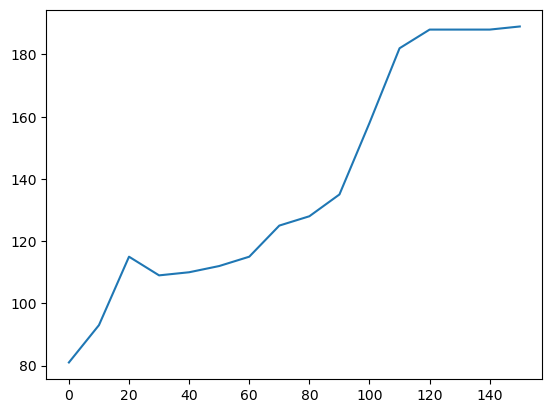

In [18]:
import numpy as np
epoch = np.arange(0,151,10)
sns.lineplot(x = epoch, y = acc_plot)